In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
import geohash2
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import shap
from datetime import timedelta

# Suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## INCIDENTS PER STATION PER MONTH

In [2]:
# Read the CSV files into DataFrames

# Path to the folder containing the files
folder_path = "/Users/medhinisridharr/Documents/University of Rochester/Courses/Fall 2024/Capstone Project/Cleaned Incident Data/Month Wise Aggregation/Per Station per Month"

# Mapping of DataFrame names to corresponding file names
file_mapping = {
    "Engine 1": "Engine 1_monthly.csv",
    "Engine 2": "Engine 2_monthly.csv",
    "Engine 3": "Engine 3_monthly.csv",
    "Engine 5": "Engine 5_monthly.csv",
    "Engine 7": "Engine 7_monthly.csv",
    "Engine 8": "Engine 8_monthly.csv",
    "Engine 9": "Engine 9_monthly.csv",
    "Engine 10/Truck 2": "Engine 10_truck 2_monthly.csv",
    "Engine 12": "Engine 12_monthly.csv",
    "Engine 13/Truck 10": "Engine 13_truck 10_monthly.csv",
    "Engine 16/Truck 6": "Engine 16_truck 6_monthly.csv",
    "Engine 17/Rescue 11": "Engine 17_rescue 11_monthly.csv",
    "Engine 19": "Engine 19_monthly.csv",
    "Truck 3": "Truck 3_monthly.csv",
    "Truck 4": "Truck 4_monthly.csv",
    "Truck 5": "Truck 5_monthly.csv",
}

# Dictionary to hold the loaded DataFrames
dataframes = {}

# Loop through the file mapping and load each file into the dictionary
for df_name, file_name in file_mapping.items():
    file_path = os.path.join(folder_path, file_name)
    dataframes[df_name] = pd.read_csv(file_path, low_memory=False)
    print(f"{df_name} loaded with shape: {dataframes[df_name].shape}")

Engine 1 loaded with shape: (225, 98)
Engine 2 loaded with shape: (225, 98)
Engine 3 loaded with shape: (225, 98)
Engine 5 loaded with shape: (225, 98)
Engine 7 loaded with shape: (225, 98)
Engine 8 loaded with shape: (225, 98)
Engine 9 loaded with shape: (225, 98)
Engine 10/Truck 2 loaded with shape: (225, 98)
Engine 12 loaded with shape: (225, 98)
Engine 13/Truck 10 loaded with shape: (225, 98)
Engine 16/Truck 6 loaded with shape: (225, 98)
Engine 17/Rescue 11 loaded with shape: (225, 98)
Engine 19 loaded with shape: (225, 98)
Truck 3 loaded with shape: (225, 98)
Truck 4 loaded with shape: (225, 98)
Truck 5 loaded with shape: (225, 98)


In [3]:
#Creating this to easily access/iterate over all stations data
st_names = ['df_'+i.lower().replace(' ','_')+'_monthly_fs' for i in file_mapping.keys()]
st_names = [i.replace('/','_') for i in st_names]

### FEATURE SELECTION: Random Forests

In [4]:
from sklearn.model_selection import TimeSeriesSplit
import shap

In [5]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#Saving acf plots for each station to decide lags
output_dir = '/Users/medhinisridharr/Documents/University of Rochester/Courses/Fall 2024/Capstone Project/monthly_incident_counts/acf_plots'
saved_files = []
for n, d in zip(st_names, dataframes.values()):
    try:
        fig, ax = plt.subplots(figsize=(10, 6))  # Explicitly create a figure and axes
        plot_acf(d["monthly_incidents_per_nearest_station_count"], ax=ax, title=f"Autocorrelation - {n}")
        filename = f"{output_dir}/acf_plot_{n}.png"
        fig.savefig(filename, bbox_inches='tight')  # Save the specific figure
        plt.close(fig)  # Close the specific figure
        saved_files.append(filename)
    except Exception as e:
        print(f"Error processing {n}: {e}")

In [6]:
#Created lag_dict to add in lag values based on ACF plots
lag_dict = {
    'Engine 1': [1, 3, 12],
    'Engine 2': [1, 3, 12],
    'Engine 3': [1, 12],
    'Engine 5': [1, 3, 12],
    'Engine 7': [1, 12],
    'Engine 8': [1, 12],
    'Engine 9': [1, 3, 12],
    'Engine 10/Truck 2': [1, 3, 12],
    'Engine 12': [1, 3, 12],
    'Engine 13/Truck 10': [1, 12],
    'Engine 16/Truck 6': [1, 3, 12],
    'Engine 17/Rescue 11': [1, 3, 12],
    'Engine 19': [1, 3, 12],
    'Truck 3': [1, 12],
    'Truck 4': [1, 3, 12],
    'Truck 5': [1, 3, 12]
}

preprocess_dataframe() is created to further preprocess each dataframe (for each station). 
- Drop more features based on domain knowledge & discussions with RFD team
- Add lags using dictionary defined above
- Create is_covid binary indicator column

In [7]:
df_list = []

def preprocess_dataframe(name, df, df_list=df_list):
    print(f"Processing {name}...")
    
    df['alarmnum_1.0'] = df['alarmnum_1.0'] + df['alarmnum_0.0']
    df['alarmnum_5.0'] = df['alarmnum_5.0'] + df['alarmnum_6.0'] + df['alarmnum_8.0']    
    
    # Drop irrelevant column
    df = df.drop([i for i in df.columns if df[i].nunique() == 1]+['PERSIDMAKEREP','alarmnum_0.0','alarmnum_6.0','alarmnum_8.0','is_weekend_1']+[i for i in df.columns if (i.startswith('sitfound'))|(i.startswith('expnum'))], axis=1)
    
    # Create lagged features
    for i in lag_dict[name]:
        df['lag_' + str(i)] = df['monthly_incidents_per_nearest_station_count'].shift(i)
    
    # Drop rows with NaN values
    df = df.dropna().reset_index(drop=True)
        
    mask = ((df['datetimealarm_month_year'] >= '2020-03') & 
             (df['datetimealarm_month_year'] <= '2021-06'))
    df['is_covid'] = np.where(mask, 1, 0)
    
    
    return df

In [8]:
for (name, k) in zip(st_names, dataframes.keys()):
    globals()[name] = preprocess_dataframe(k, dataframes[k])
    df_list.append(globals()[name])

Processing Engine 1...
Processing Engine 2...
Processing Engine 3...
Processing Engine 5...
Processing Engine 7...
Processing Engine 8...
Processing Engine 9...
Processing Engine 10/Truck 2...
Processing Engine 12...
Processing Engine 13/Truck 10...
Processing Engine 16/Truck 6...
Processing Engine 17/Rescue 11...
Processing Engine 19...
Processing Truck 3...
Processing Truck 4...
Processing Truck 5...


### Multicollinearity Analysis

In [9]:
#Function to get strongly correlated pairs
def create_corr_dict(df, threshold = 0.7):
    corr_df = df.drop(['monthly_incidents_per_nearest_station_count','datetimealarm_month_year'],axis=1)
    corr_df = corr_df.corr()
    strong_corr_dict = {}
    for col in corr_df.columns:
        strongly_corr_cols = list(corr_df[corr_df[col]>threshold].index)
        try:
            strongly_corr_cols.remove(col)
        except ValueError:
            pass
        if len(strongly_corr_cols) > 0:
            strong_corr_dict[col] = strongly_corr_cols
    return strong_corr_dict

#Function to output feature from strongly correlated features pair that has lower correlation with target - this one is dropped
def less_imp_feat(f1, f2, df, target = 'monthly_incidents_per_nearest_station_count'):
    correl_f1 = df[target].corr(df[f1])
    correl_f2 = df[target].corr(df[f2])
    if correl_f1 >= correl_f2:
        return f2
    else:
        return f1

In [10]:
station_shap_values = []
station_feature_names = []
rf_feature_importances = []
station_feature_importances = []

def handle_correlations_and_select_features(station_name, df, correlation_threshold=0.7):
    """
    Handle highly correlated features and perform feature selection for a station.

    Parameters:
        station_name (str): Name of the station.
        df (pd.DataFrame): Monthly data for the station.
        correlation_threshold (float): Threshold to consider features as highly correlated.

    Returns:
        selected_features (list): List of selected features after RF + SHAP.
        updated_df (pd.DataFrame): DataFrame with handled correlations.
    """
    print(f"Processing {station_name}...")
    
    df = df.drop(['PERSIDMAKEREP','nearest_station_name'], axis=1)
    
    # Create lagged features
    for lag in lag_dict[station_name]:
        df['lag_' + str(lag)] = df['monthly_incidents_per_nearest_station_count'].shift(lag)
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    strong_corr_dict = create_corr_dict(df)
    
    #Based on domain knowledge, mentioning columns that we prefer to drop if they are highly correlated
    drop_preference = [i for i in df.columns if (i.startswith('loctype_descr_')) | (i.startswith('schdshiftname_descr'))]    
    drop_cols = [i for i in strong_corr_dict.keys() if i in drop_preference]
    df = df.drop(drop_cols,axis=1)

    # Step 1: Identify Highly Correlated Features
    corr_matrix = df.drop(['monthly_incidents_per_nearest_station_count','datetimealarm_month_year'],axis=1)
    corr_matrix = corr_matrix.corr()
    strong_corr_pairs = [
        (corr_matrix.columns[i], corr_matrix.columns[j])
        for i in range(len(corr_matrix.columns))
        for j in range(i + 1, len(corr_matrix.columns))
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold]
    
    # Base dictionary - Created based on domain knowledge - Feature pairs between which interactions should be allowed
    allow_interactions = {
        'alarmnum_1.0': ['alarmnum_2.0'],  # Interaction between low severity levels
        'alarmnum_3.0': ['alarmnum_4.0', 'alarmnum_5.0'],  # Interaction between mid and high severity levels

        # Specific Incident Type Interactions
        'inctype_grouped_descr_Rescue & EMS': ['civilian_injuries'],  # Injuries align with EMS
        'inctype_grouped_descr_Severe Weather': ['civilian_deaths', 'civilian_injuries'],  # Weather-related impacts

        # Civilian Impact
        'civilian_deaths': ['alarmnum_4.0', 'alarmnum_5.0', 
                            'inctype_grouped_descr_Structure Fires', 
                            'inctype_grouped_descr_Severe Weather',
                            'civilian_injuries', 'fire_service_injuries'],  # Fatalities linked to high severity

        'time_to_reach': ['latitude', 'longitude'],  # Response times linked to location

        # Geographic Information
        'latitude': ['longitude'],  # Location interaction
    }

    # Dynamically add all combinations of inctype_grouped_descr_* and alarmnum_*
    inctype_grouped_features = [inc_type for inc_type in df.columns if inc_type.startswith('inctype_grouped_descr_')]
    alarmnum_features = [alarm for alarm in df.columns if alarm.startswith('alarmnum_')]

    # Add all combinations to the dictionary
    for inctype_feature in inctype_grouped_features:
        for alarmnum_feature in alarmnum_features:
            if inctype_feature not in allow_interactions:
                allow_interactions[inctype_feature] = []
            allow_interactions[inctype_feature].append(alarmnum_feature)

    for feature1, feature2 in strong_corr_pairs:
        if (feature1 in df.columns) & (feature2 in df.columns):
            if feature1 in allow_interactions and feature2 in allow_interactions[feature1]:
                # Create an interaction term
                interaction_name = f"{feature1}_x_{feature2}"
                df[interaction_name] = df[feature1] * df[feature2]
                df = df.drop([feature1, feature2],axis=1)
            else:
                # Drop one of the features (e.g., based on domain knowledge or SHAP values)
                less_important_feature = less_imp_feat(feature1, feature2, df)
                print(f"Dropping {less_important_feature}")
                df = df.drop(columns=[less_important_feature])
                
    # Define features and target
    X = df.drop(columns=['monthly_incidents_per_nearest_station_count','datetimealarm_month_year'])
    y = df['monthly_incidents_per_nearest_station_count']
    
    # Initialize Random Forest model
    model = RandomForestRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Cross-validation metrics
    r2_scores = []
    rmse_scores = []

    # Cross-validation
    print("Starting Time-Series Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"Fold {fold + 1}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        
        print(f"  R2 Score: {r2:.4f}")
        print(f"  RMSE: {rmse:.4f}")
    
    print("\nCross-Validation Results:")
    print(f"Average R2 Score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

    # Final training on full dataset
    model.fit(X, y)

    # Extract RF feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    rf_feature_importances.append({"station_name": station_name, "rf_importances": feature_importances})
    
    # SHAP feature importance analysis
    print("Analyzing feature importance using SHAP...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Store SHAP values and feature names for later analysis
    station_shap_values.append({"station_name": station_name, "shap_values": shap_values})
    station_feature_names.append({"station_name": station_name, "feature_names": X.columns.tolist()})
    
    shap_importances = np.abs(shap_values).mean(axis=0)
    
    important_features = list(X.columns[np.argsort(shap_importances)[::-1][:10]])  # Top 10 features
    station_feature_importances.append({"station_name": name, "important_features": important_features})
    
    print(f"Top 10 features for {station_name}: {important_features}")

    # Visualize SHAP values
    print(f"Generating SHAP summary plot for {station_name}...")
    shap.summary_plot(shap_values, features=X, feature_names=X.columns)

Processing Engine 1...
Dropping day_name_Saturday
Dropping expnum_0
Dropping inctype_grouped_descr_False Calls
Dropping inctype_grouped_descr_Good Intent
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_321.0
Dropping expnum_2
Dropping expnum_4
Dropping expnum_5
Dropping expnum_6
Dropping sitfound_412.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.6743
  RMSE: 10.7733
Fold 2
  R2 Score: 0.9801
  RMSE: 2.3707
Fold 3
  R2 Score: 0.9733
  RMSE: 3.8786
Fold 4
  R2 Score: 0.9071
  RMSE: 8.5908
Fold 5
  R2 Score: 0.6370
  RMSE: 20.6307

Cross-Validation Results:
Average R2 Score: 0.8344 ± 0.1486
Average RMSE: 9.2488 ± 6.4568
Analyzing feature importance using SHAP...
Top 10 features for Engine 1: ['alarmnum_1.0', 'count_all_units', 'hour_of_day_3', 'hour_of_day_6', 'lag_12', 'sitfound_311.0', 'day_name_Monday', 'longitude', 'day_name_Tuesday', 'hour_of_day_15']
Generating SHAP summary plot for 

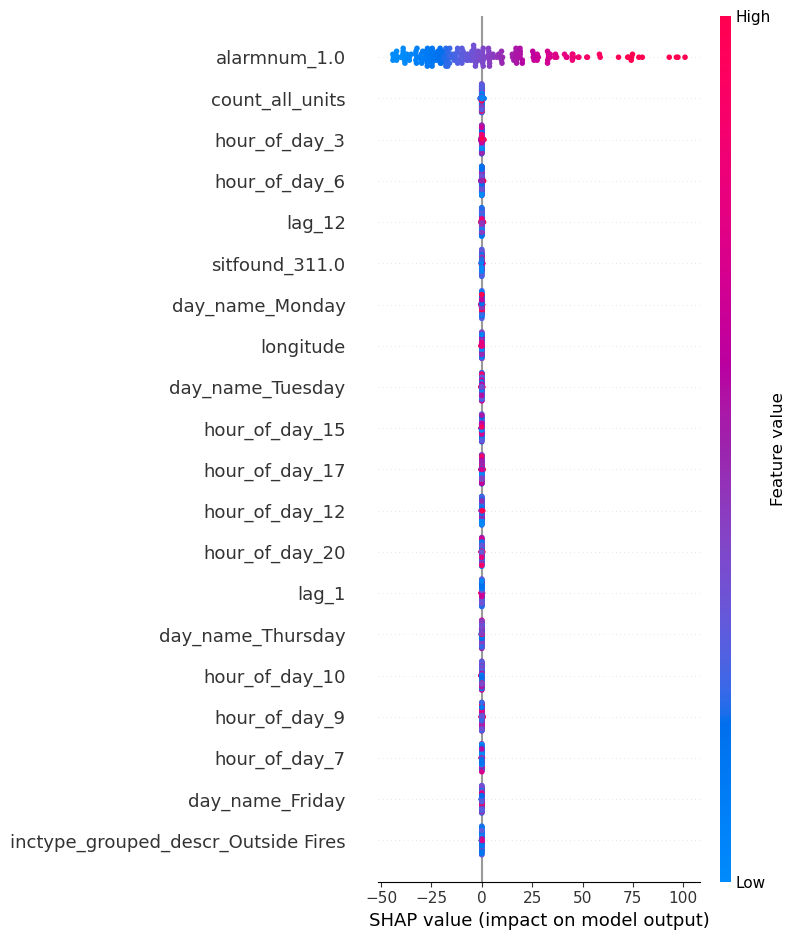

Processing Engine 2...
Dropping day_name_Friday
Dropping day_name_Monday
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping day_name_Thursday
Dropping day_name_Tuesday
Dropping day_name_Wednesday
Dropping expnum_0
Dropping inctype_grouped_descr_Good Intent
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_321.0
Dropping lag_1
Dropping lag_3
Dropping lag_12
Dropping expnum_3
Dropping expnum_4
Dropping expnum_6
Dropping sitfound_412.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9795
  RMSE: 4.0125
Fold 2
  R2 Score: 0.9058
  RMSE: 9.3683
Fold 3
  R2 Score: 0.9831
  RMSE: 4.0468
Fold 4
  R2 Score: 0.6027
  RMSE: 41.7673
Fold 5
  R2 Score: 0.7219
  RMSE: 22.6527

Cross-Validation Results:
Average R2 Score: 0.8386 ± 0.1513
Average RMSE: 16.3695 ± 14.4089
Analyzing feature importance using SHAP...
Top 10 features for Engine 2: ['alarmnum_1.0', 'inctype_grouped_descr_Service Calls', 'h

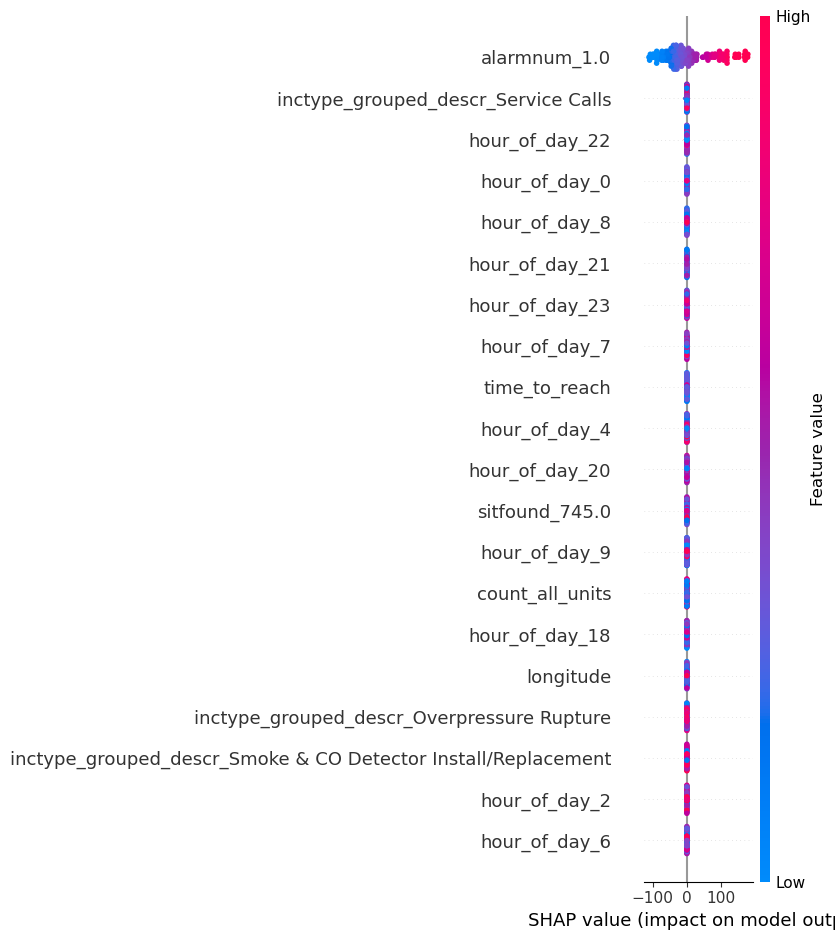

Processing Engine 3...
Dropping day_name_Monday
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping day_name_Thursday
Dropping day_name_Tuesday
Dropping expnum_0
Dropping inctype_grouped_descr_Good Intent
Dropping inctype_grouped_descr_Motor Vehicle Accident
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_321.0
Dropping lag_1
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9360
  RMSE: 3.2260
Fold 2
  R2 Score: 0.8726
  RMSE: 5.7219
Fold 3
  R2 Score: 0.9678
  RMSE: 3.3688
Fold 4
  R2 Score: 0.6633
  RMSE: 19.5715
Fold 5
  R2 Score: 0.5938
  RMSE: 10.0084

Cross-Validation Results:
Average R2 Score: 0.8067 ± 0.1503
Average RMSE: 8.3793 ± 6.1097
Analyzing feature importance using SHAP...
Top 10 features for Engine 3: ['alarmnum_1.0', 'time_to_reach', 'hour_of_day_9', 'longitude', 'day_name_Wednesday', 'civilian_injuries', 'inctype_grouped_descr_Smoke & CO Detector Install/Replacemen

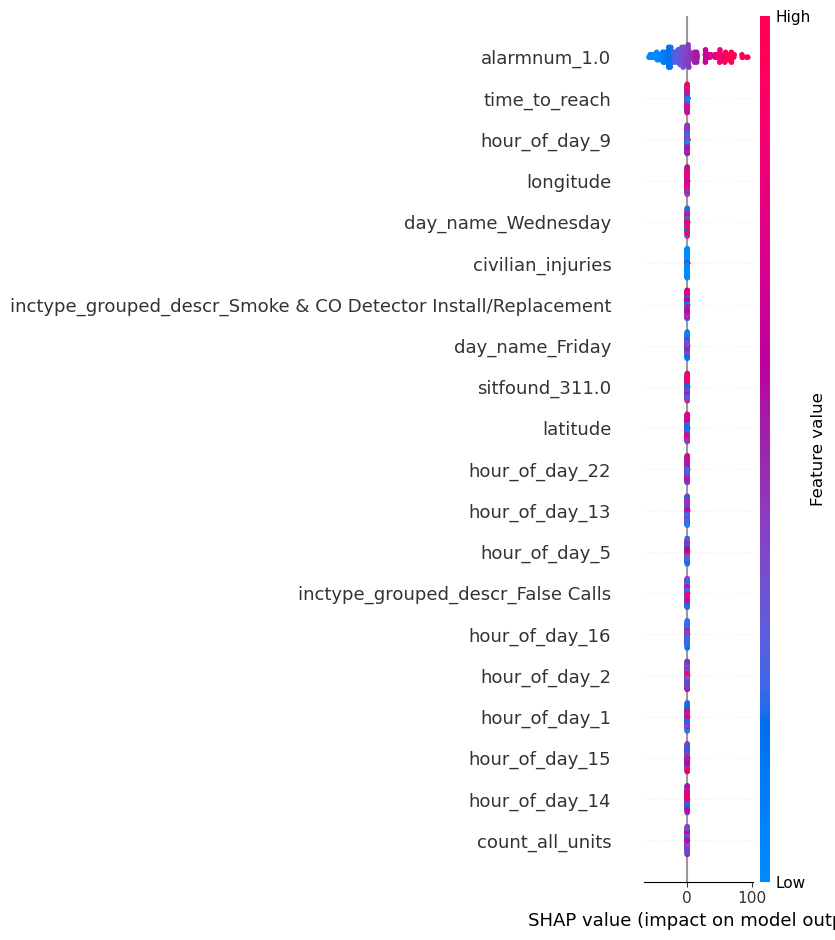

Processing Engine 5...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping expnum_3
Dropping count_all_units
Dropping sitfound_321.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.8273
  RMSE: 9.6711
Fold 2
  R2 Score: 0.9818
  RMSE: 2.1792
Fold 3
  R2 Score: 0.8929
  RMSE: 7.7967
Fold 4
  R2 Score: 0.8116
  RMSE: 13.2868
Fold 5
  R2 Score: 0.9794
  RMSE: 3.8671

Cross-Validation Results:
Average R2 Score: 0.8986 ± 0.0723
Average RMSE: 7.3602 ± 3.9925
Analyzing feature importance using SHAP...
Top 10 features for Engine 5: ['alarmnum_1.0', 'hour_of_day_20', 'day_name_Tuesday', 'inctype_grouped_descr_Hazardous Condition', 'day_name_Wednesday', 'sitfound_311.0', 'day_name_Thursday', 'inctype_grouped_descr_Good Intent', 'hour_of_day_15', 'latitude']
Generating SHAP summary plot for Engine 5...


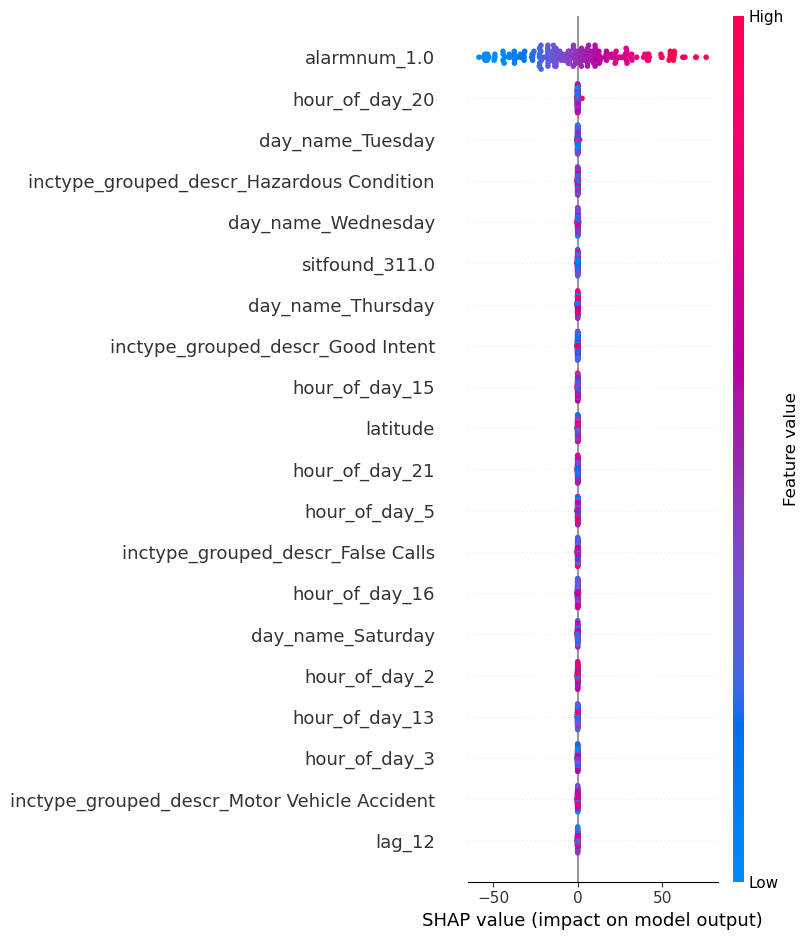

Processing Engine 7...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_745.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9630
  RMSE: 2.6095
Fold 2
  R2 Score: 0.9805
  RMSE: 2.5718
Fold 3
  R2 Score: 0.8953
  RMSE: 7.0581
Fold 4
  R2 Score: 0.9127
  RMSE: 7.0418
Fold 5
  R2 Score: 0.9881
  RMSE: 2.2231

Cross-Validation Results:
Average R2 Score: 0.9479 ± 0.0372
Average RMSE: 4.3008 ± 2.2487
Analyzing feature importance using SHAP...
Top 10 features for Engine 7: ['alarmnum_1.0', 'hour_of_day_2', 'hour_of_day_11', 'latitude', 'hour_of_day_18', 'day_name_Thursday', 'schdshiftname_descr_Group 1', 'inctype_grouped_descr_Smoke & CO Detector Install/Replacement', 'hour_of_day_14', 'lag_12']
Generating SHAP summary plot for Engine 7...


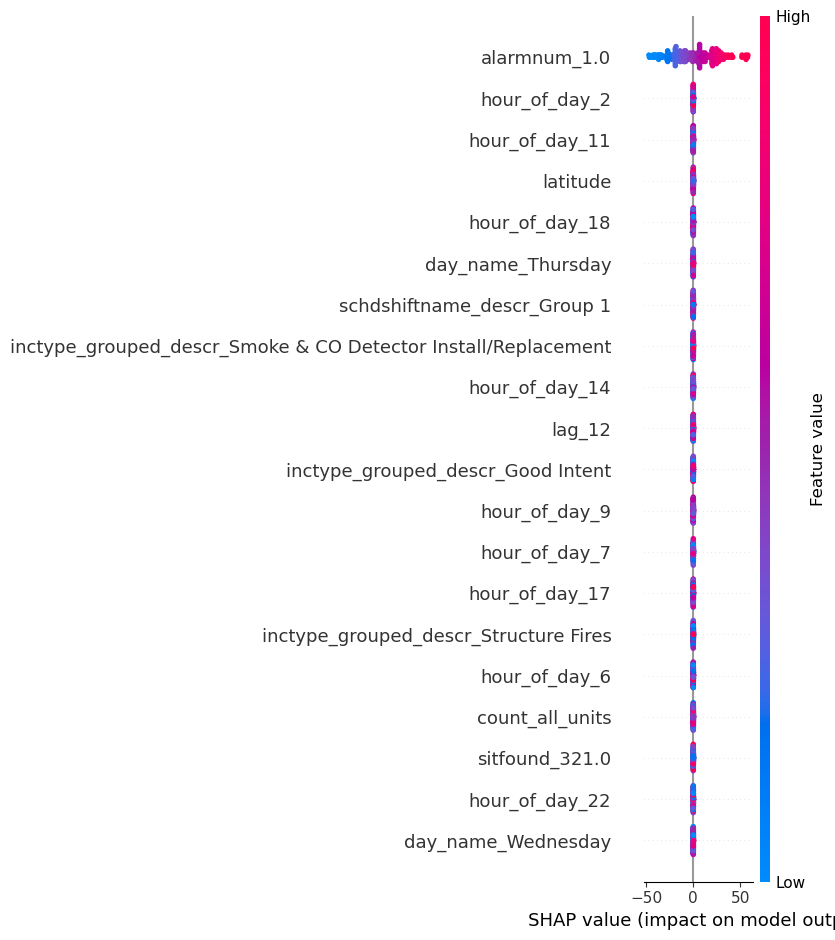

Processing Engine 8...
Dropping alarmnum_1.0
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping inctype_grouped_descr_False Calls
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9176
  RMSE: 1.5277
Fold 2
  R2 Score: 0.9229
  RMSE: 1.8102
Fold 3
  R2 Score: 0.8945
  RMSE: 2.0236
Fold 4
  R2 Score: 0.9977
  RMSE: 0.3201
Fold 5
  R2 Score: 0.6994
  RMSE: 5.5290

Cross-Validation Results:
Average R2 Score: 0.8864 ± 0.0997
Average RMSE: 2.2421 ± 1.7460
Analyzing feature importance using SHAP...
Top 10 features for Engine 8: ['expnum_0', 'sitfound_321.0', 'hour_of_day_15', 'count_all_units', 'hour_of_day_21', 'latitude', 'hour_of_day_7', 'lag_1', 'hour_of_day_0', 'hour_of_day_20']
Generating SHAP summary plot for Engine 8...


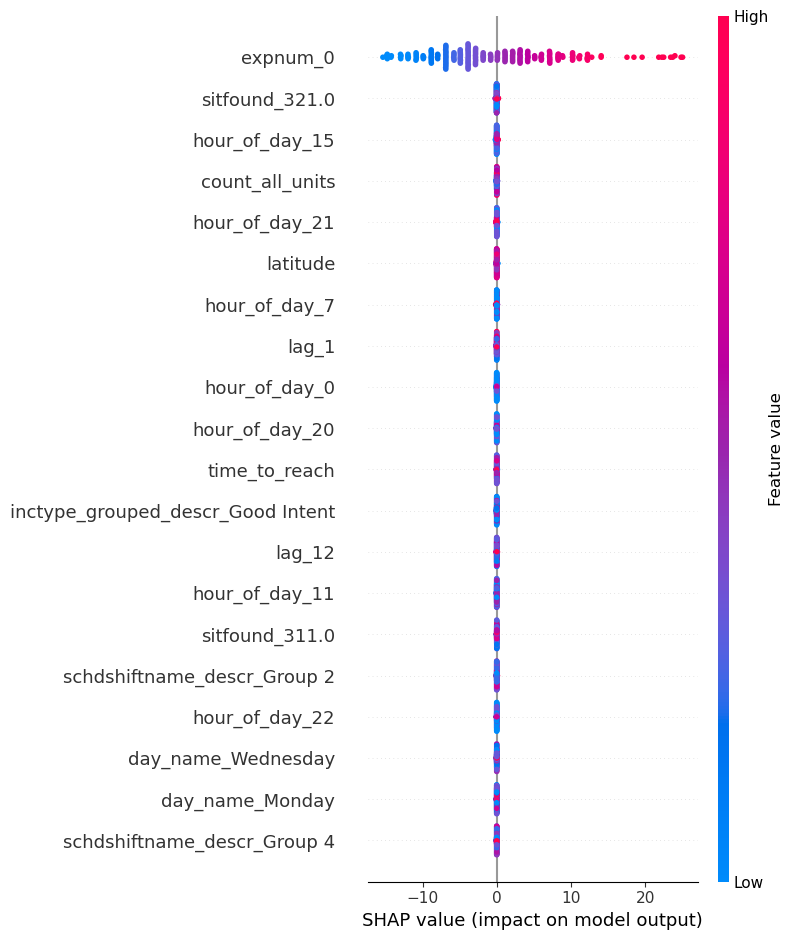

Processing Engine 9...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping sitfound_0.0
Dropping sitfound_321.0
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping inctype_grouped_descr_Citizen Complaint
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9453
  RMSE: 6.0052
Fold 2
  R2 Score: 0.9942
  RMSE: 1.4286
Fold 3
  R2 Score: 0.8970
  RMSE: 7.4573
Fold 4
  R2 Score: 0.9275
  RMSE: 10.0114
Fold 5
  R2 Score: 0.9393
  RMSE: 6.4507

Cross-Validation Results:
Average R2 Score: 0.9407 ± 0.0315
Average RMSE: 6.2706 ± 2.7910
Analyzing feature importance using SHAP...
Top 10 features for Engine 9: ['alarmnum_1.0', 'lag_3', 'hour_of_day_23', 'is_weekend_1', 'lag_1', 'hour_of_day_13', 'inctype_grouped_descr_False Calls', 'hour_of_day_3', 'day_name_Thursday', 'latitude']
Generating SHAP summary plot for Engine 9...


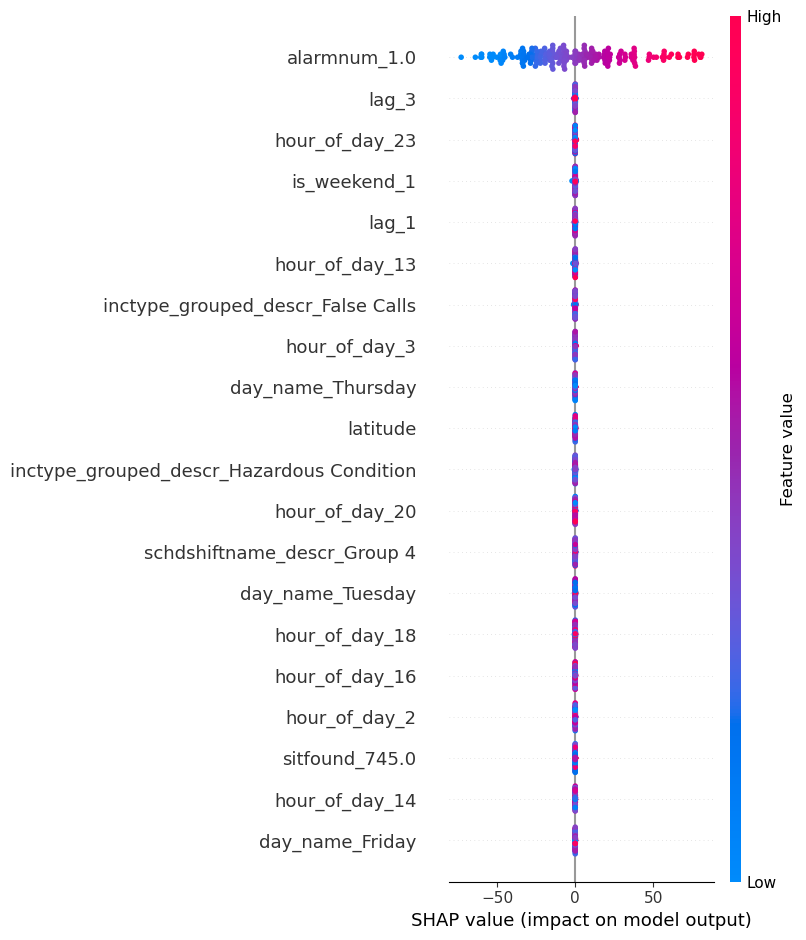

Processing Engine 10/Truck 2...
Dropping day_name_Friday
Dropping day_name_Monday
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping day_name_Thursday
Dropping day_name_Tuesday
Dropping expnum_0
Dropping inctype_grouped_descr_Good Intent
Dropping inctype_grouped_descr_Motor Vehicle Accident
Dropping inctype_grouped_descr_Rescue & EMS
Dropping inctype_grouped_descr_Service Calls
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_321.0
Dropping lag_1
Dropping lag_3
Dropping lag_12
Dropping expnum_4
Dropping sitfound_745.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9693
  RMSE: 3.4492
Fold 2
  R2 Score: 0.7337
  RMSE: 11.3876
Fold 3
  R2 Score: 0.9891
  RMSE: 2.2766
Fold 4
  R2 Score: 0.1799
  RMSE: 58.6501
Fold 5
  R2 Score: 0.8098
  RMSE: 14.6791

Cross-Validation Results:
Average R2 Score: 0.7364 ± 0.2943
Average RMSE: 18.0885 ± 20.8139
Analyzing feature importance using SHAP...
Top 10 features for Engine 10/Truck 2: ['al

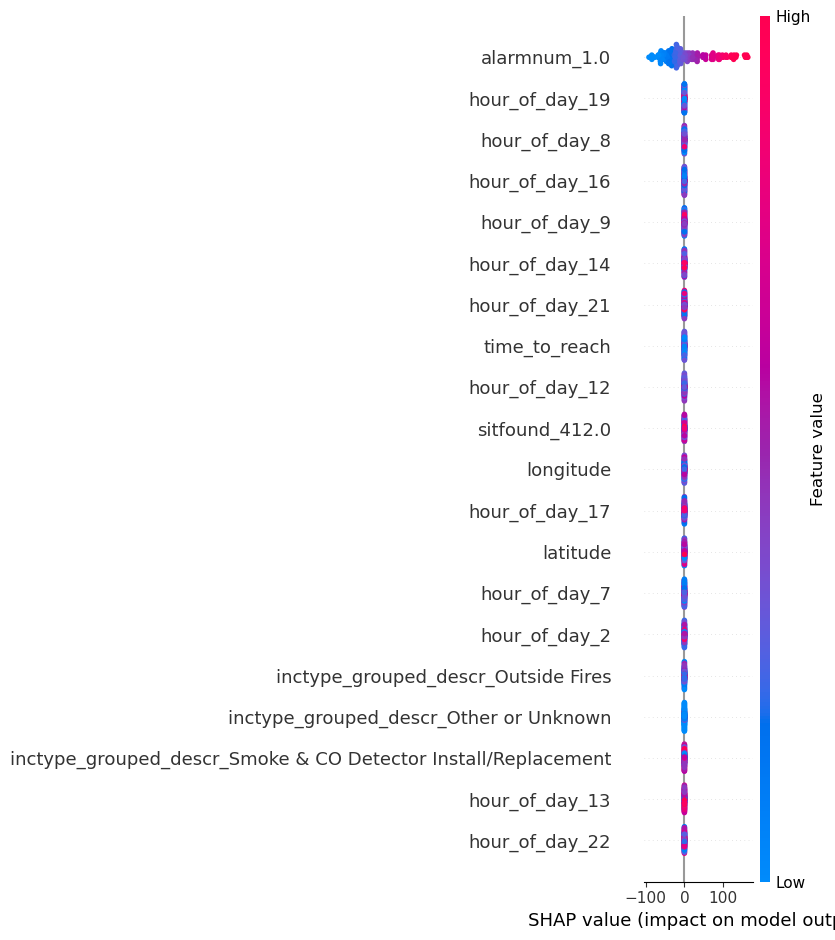

Processing Engine 12...
Dropping expnum_0
Dropping sitfound_0.0
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping sitfound_321.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9064
  RMSE: 2.8657
Fold 2
  R2 Score: 0.9868
  RMSE: 0.9858
Fold 3
  R2 Score: 0.9531
  RMSE: 2.1075
Fold 4
  R2 Score: 0.9924
  RMSE: 0.8950
Fold 5
  R2 Score: 0.9854
  RMSE: 0.9352

Cross-Validation Results:
Average R2 Score: 0.9648 ± 0.0323
Average RMSE: 1.5578 ± 0.7959
Analyzing feature importance using SHAP...
Top 10 features for Engine 12: ['alarmnum_1.0', 'day_name_Tuesday', 'lag_3', 'schdshiftname_descr_Group 2', 'hour_of_day_12', 'hour_of_day_10', 'inctype_grouped_descr_Rescue & EMS', 'inctype_grouped_descr_Service Calls', 'inctype_grouped_descr_Smoke & CO Detector Install/Replacement', 'schdshiftname_descr_Group 4']
Generating SHAP summary plot for Engine 12...


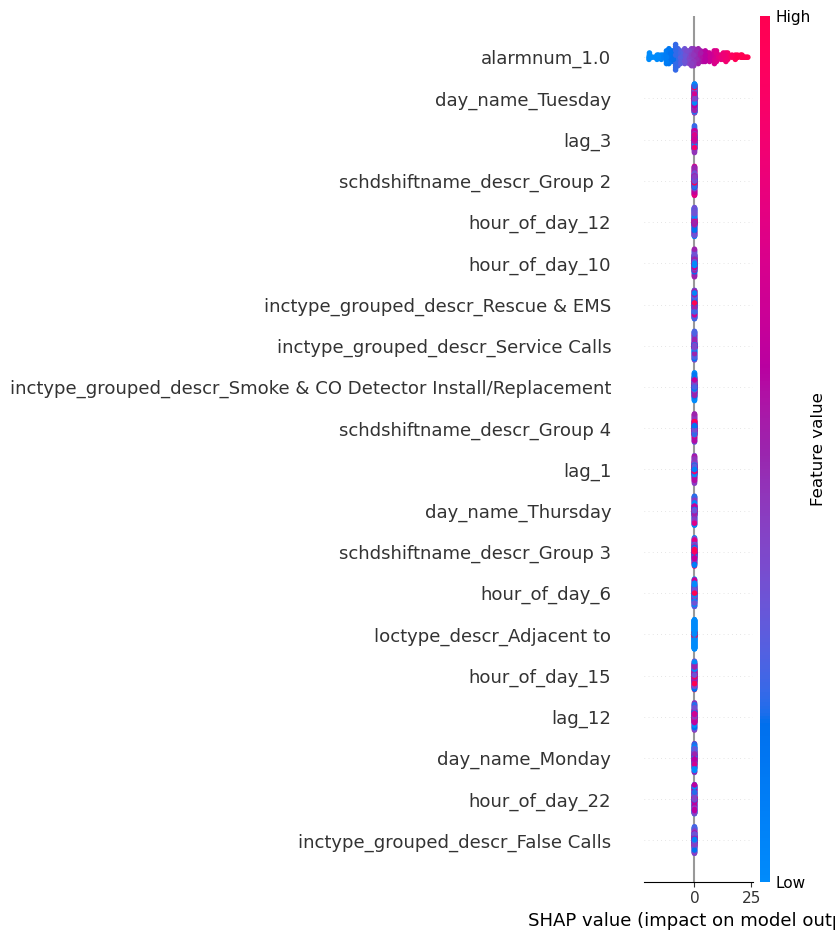

Processing Engine 13/Truck 10...
Dropping expnum_0
Dropping inctype_grouped_descr_Motor Vehicle Accident
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping lag_1
Dropping sitfound_412.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: -0.7545
  RMSE: 34.3549
Fold 2
  R2 Score: 0.8085
  RMSE: 13.7086
Fold 3
  R2 Score: 0.7702
  RMSE: 15.4863
Fold 4
  R2 Score: 0.9488
  RMSE: 11.2890
Fold 5
  R2 Score: 0.9981
  RMSE: 1.2631

Cross-Validation Results:
Average R2 Score: 0.5542 ± 0.6598
Average RMSE: 15.2204 ± 10.7587
Analyzing feature importance using SHAP...
Top 10 features for Engine 13/Truck 10: ['alarmnum_1.0', 'day_name_Tuesday', 'hour_of_day_11', 'inctype_grouped_descr_Hazardous Condition', 'day_name_Monday', 'hour_of_day_16', 'hour_of_day_4', 'hour_of_day_23', 'inctype_grouped_descr_Good Intent', 'hour_of_day_6']
Generating SHAP summary plot for Engine 13/Truck 10...


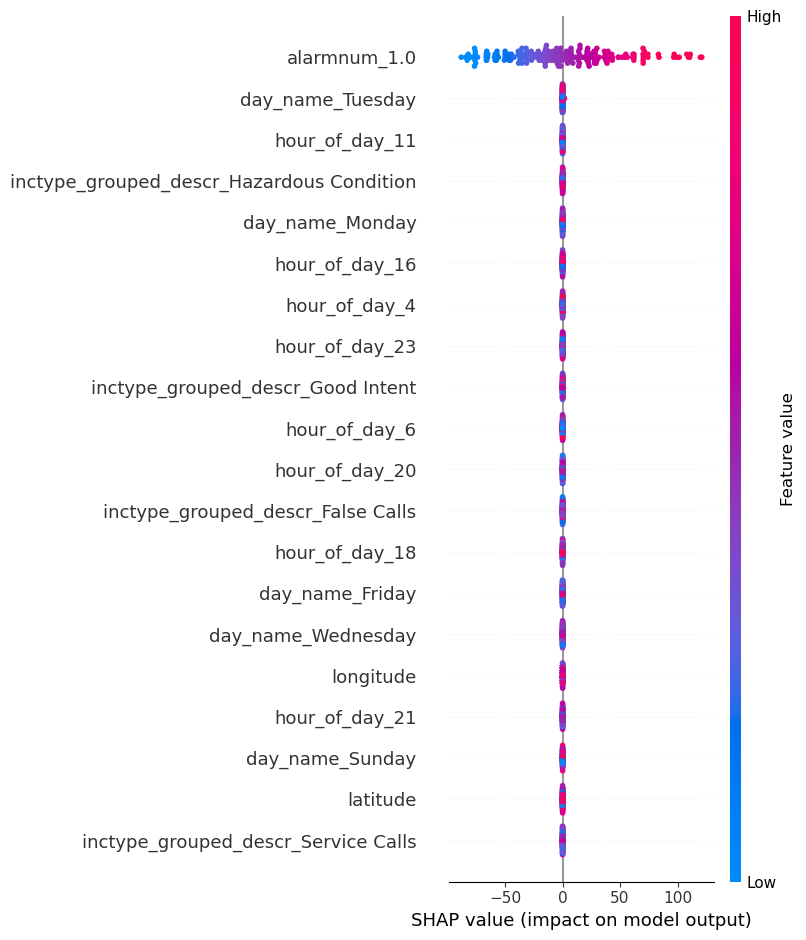

Processing Engine 16/Truck 6...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping sitfound_321.0
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping inctype_grouped_descr_Motor Vehicle Accident
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.8293
  RMSE: 8.0807
Fold 2
  R2 Score: 0.9786
  RMSE: 2.8626
Fold 3
  R2 Score: 0.9780
  RMSE: 3.2243
Fold 4
  R2 Score: 0.9009
  RMSE: 10.0116
Fold 5
  R2 Score: 0.8293
  RMSE: 10.6318

Cross-Validation Results:
Average R2 Score: 0.9032 ± 0.0667
Average RMSE: 6.9622 ± 3.3104
Analyzing feature importance using SHAP...
Top 10 features for Engine 16/Truck 6: ['alarmnum_1.0', 'day_name_Thursday', 'hour_of_day_1', 'is_weekend_1', 'hour_of_day_9', 'hour_of_day_4', 'lag_1', 'sitfound_0.0', 'schdshiftname_descr_Group 3', 'hour_of_day_18']
Generating SHAP summary plot for Engine 16/Truck 6...


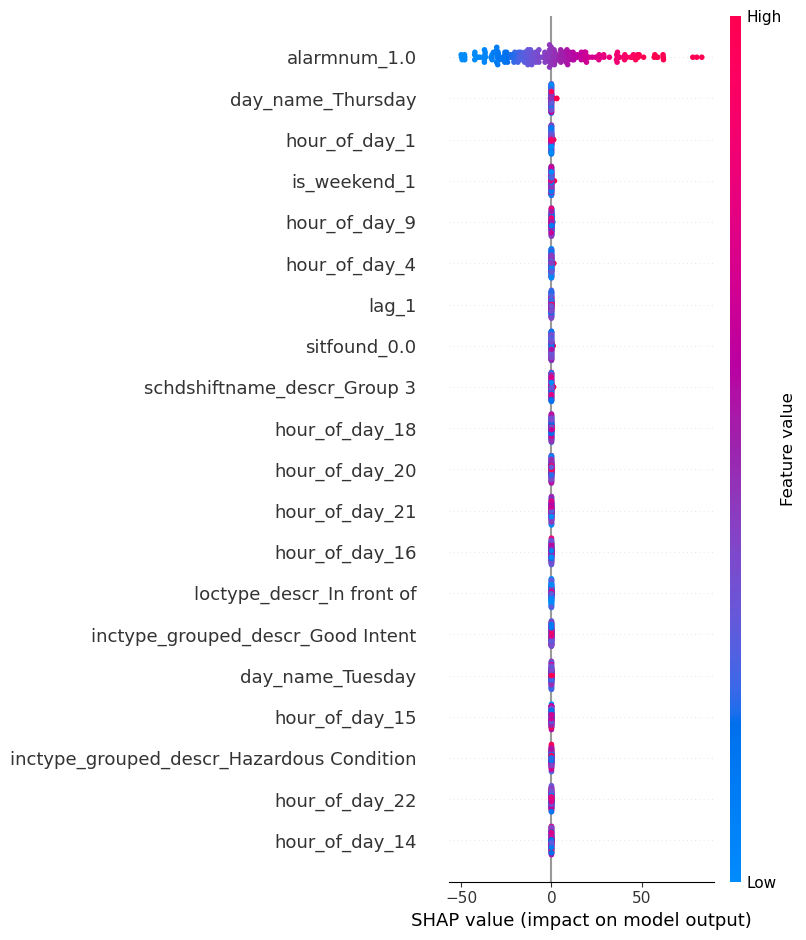

Processing Engine 17/Rescue 11...
Dropping day_name_Friday
Dropping day_name_Monday
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping day_name_Thursday
Dropping day_name_Tuesday
Dropping day_name_Wednesday
Dropping expnum_0
Dropping hour_of_day_16
Dropping hour_of_day_17
Dropping hour_of_day_18
Dropping hour_of_day_19
Dropping inctype_grouped_descr_Motor Vehicle Accident
Dropping inctype_grouped_descr_Rescue & EMS
Dropping inctype_grouped_descr_Service Calls
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_311.0
Dropping lag_1
Dropping lag_3
Dropping lag_12
Dropping alarmnum_8.0
Dropping expnum_3
Dropping expnum_4
Dropping expnum_5
Dropping expnum_6
Dropping expnum_11
Dropping expnum_7
Dropping expnum_8
Dropping expnum_9
Dropping sitfound_412.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.3107
  RMSE: 37.2732
Fold 2
  R2 Score: 0.6413
  RMSE: 23.4994
Fold 3
  R2 Score: 0.8567
  RMSE: 14.0124
Fold 4
  R2 Score: 0.9880
  R

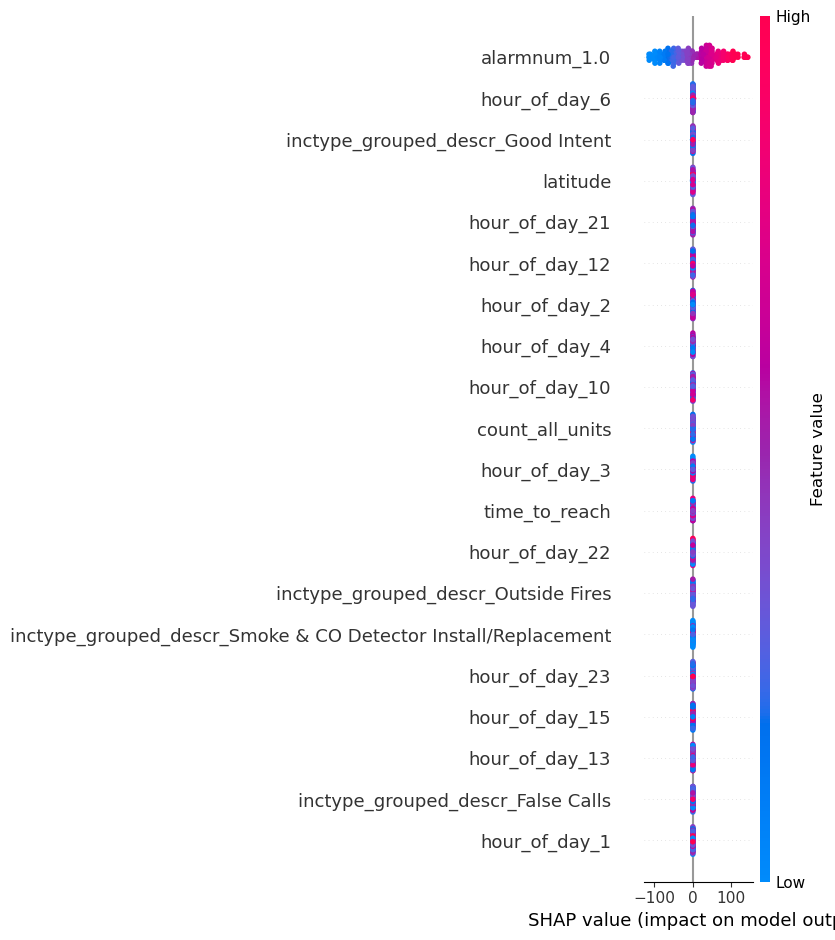

Processing Engine 19...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping is_weekend_1
Dropping sitfound_0.0
Dropping sitfound_321.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.6091
  RMSE: 5.7000
Fold 2
  R2 Score: 0.8854
  RMSE: 3.4738
Fold 3
  R2 Score: 0.9693
  RMSE: 1.4560
Fold 4
  R2 Score: 0.9833
  RMSE: 1.2061
Fold 5
  R2 Score: 0.7012
  RMSE: 8.0729

Cross-Validation Results:
Average R2 Score: 0.8297 ± 0.1492
Average RMSE: 3.9818 ± 2.6089
Analyzing feature importance using SHAP...
Top 10 features for Engine 19: ['alarmnum_1.0', 'sitfound_311.0', 'day_name_Monday', 'lag_12', 'inctype_grouped_descr_Smoke & CO Detector Install/Replacement', 'hour_of_day_15', 'day_name_Wednesday', 'hour_of_day_0', 'lag_3', 'hour_of_day_13']
Generating SHAP summary plot for Engine 19...


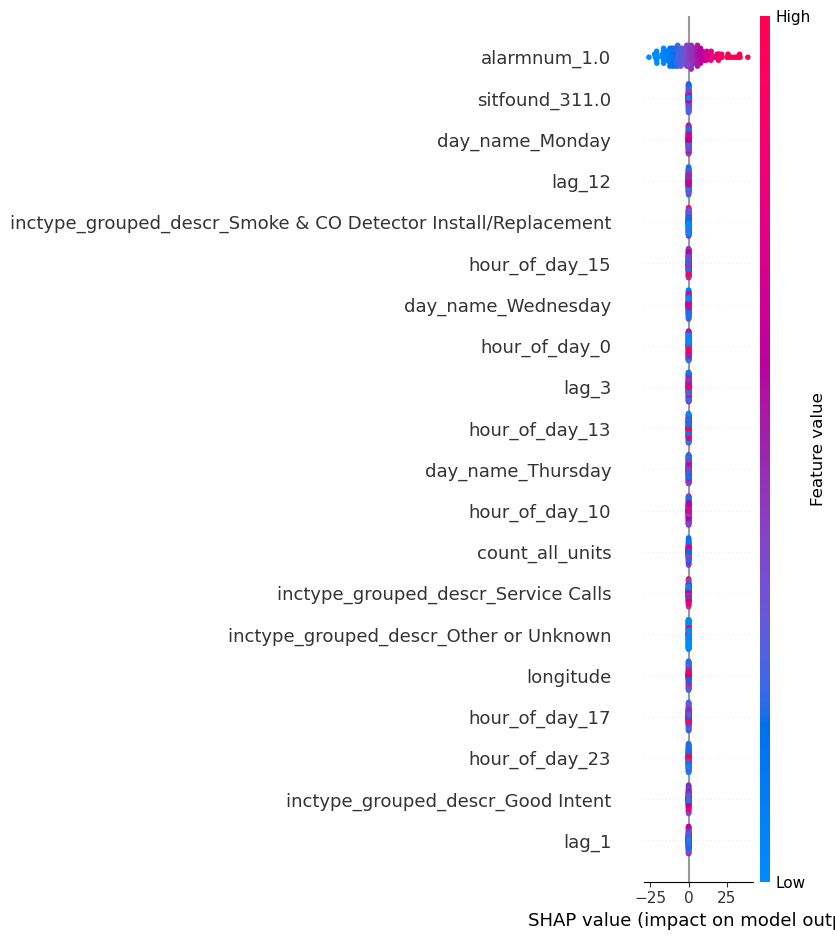

Processing Truck 3...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping sitfound_0.0
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.9522
  RMSE: 2.7540
Fold 2
  R2 Score: 0.9537
  RMSE: 2.0991
Fold 3
  R2 Score: 0.9520
  RMSE: 2.9617
Fold 4
  R2 Score: 0.9124
  RMSE: 4.7528
Fold 5
  R2 Score: 0.9379
  RMSE: 3.4236

Cross-Validation Results:
Average R2 Score: 0.9417 ± 0.0157
Average RMSE: 3.1982 ± 0.8864
Analyzing feature importance using SHAP...
Top 10 features for Truck 3: ['alarmnum_1.0', 'is_weekend_1', 'inctype_grouped_descr_Hazardous Condition', 'sitfound_321.0', 'count_all_units', 'inctype_grouped_descr_Service Calls', 'lag_1', 'hour_of_day_19', 'longitude', 'inctype_grouped_descr_Good Intent']
Generating SHAP summary plot for Truck 3...


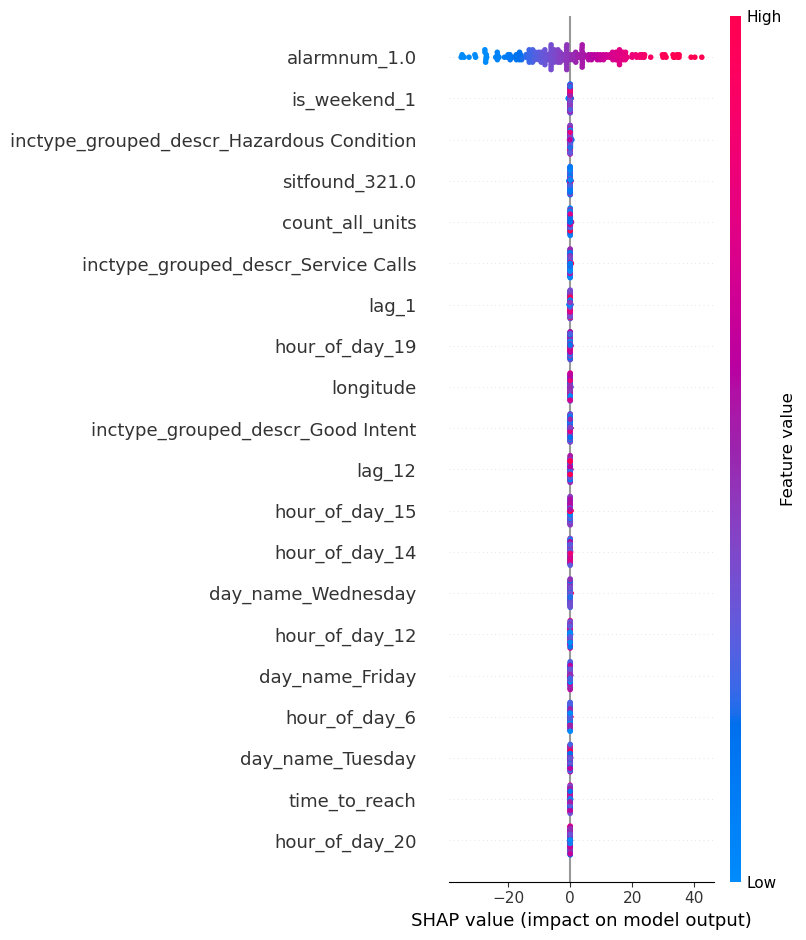

Processing Truck 4...
Dropping alarmnum_1.0
Dropping alarmnum_4.0
Dropping alarmnum_6.0
Dropping expnum_3
Dropping expnum_4
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping sitfound_0.0
Dropping sitfound_412.0
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.5316
  RMSE: 8.9720
Fold 2
  R2 Score: 0.9741
  RMSE: 1.7022
Fold 3
  R2 Score: 0.9795
  RMSE: 2.1454
Fold 4
  R2 Score: 0.9948
  RMSE: 1.1220
Fold 5
  R2 Score: 0.9930
  RMSE: 0.9202

Cross-Validation Results:
Average R2 Score: 0.8946 ± 0.1817
Average RMSE: 2.9724 ± 3.0308
Analyzing feature importance using SHAP...
Top 10 features for Truck 4: ['expnum_0', 'lag_12', 'hour_of_day_3', 'schdshiftname_descr_Group 4', 'longitude', 'inctype_grouped_descr_Severe Weather', 'hour_of_day_1', 'hour_of_day_23', 'day_name_Wednesday', 'schdshiftname_descr_Group 3']
Generating SHAP summary plot for Truck 4...


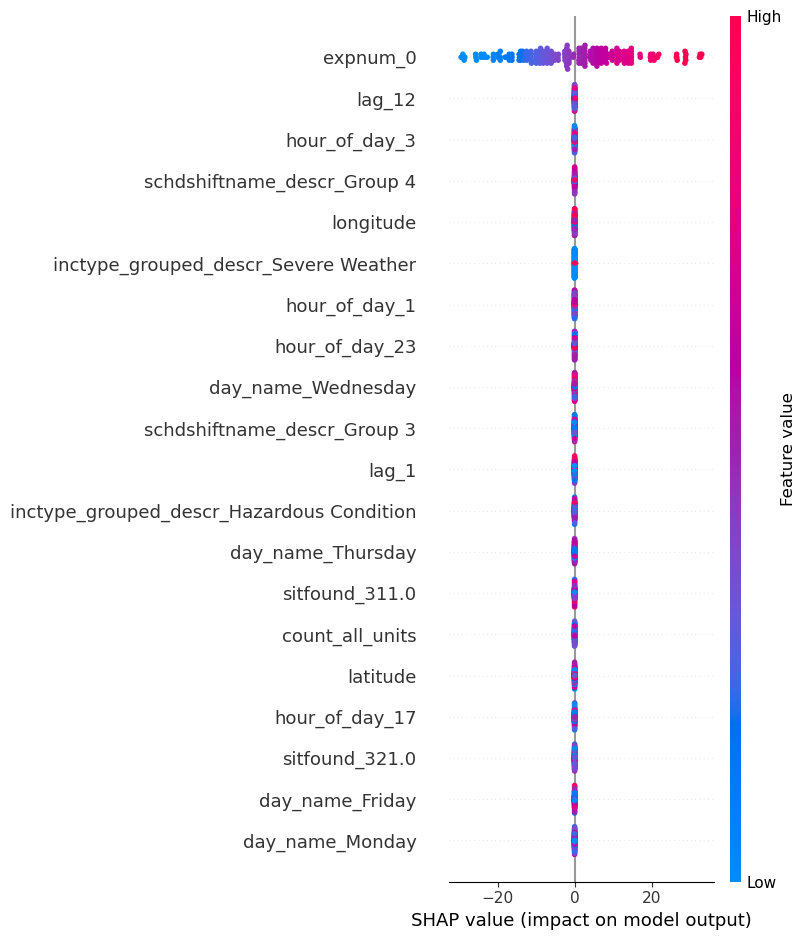

Processing Truck 5...
Dropping expnum_0
Dropping inctype_grouped_descr_Rescue & EMS
Dropping day_name_Saturday
Dropping day_name_Sunday
Dropping expnum_3
Dropping expnum_5
Dropping expnum_6
Dropping sitfound_9111.0
Starting Time-Series Cross-Validation...
Fold 1
  R2 Score: 0.6704
  RMSE: 12.7004
Fold 2
  R2 Score: 0.9387
  RMSE: 4.2252
Fold 3
  R2 Score: 0.9430
  RMSE: 5.3750
Fold 4
  R2 Score: 0.9945
  RMSE: 2.0270
Fold 5
  R2 Score: 0.9977
  RMSE: 1.1382

Cross-Validation Results:
Average R2 Score: 0.9089 ± 0.1218
Average RMSE: 5.0932 ± 4.0926
Analyzing feature importance using SHAP...
Top 10 features for Truck 5: ['alarmnum_1.0', 'hour_of_day_17', 'inctype_grouped_descr_Service Calls', 'time_to_reach', 'is_weekend_1', 'inctype_grouped_descr_Hazardous Condition', 'hour_of_day_7', 'inctype_grouped_descr_Good Intent', 'longitude', 'sitfound_0.0']
Generating SHAP summary plot for Truck 5...


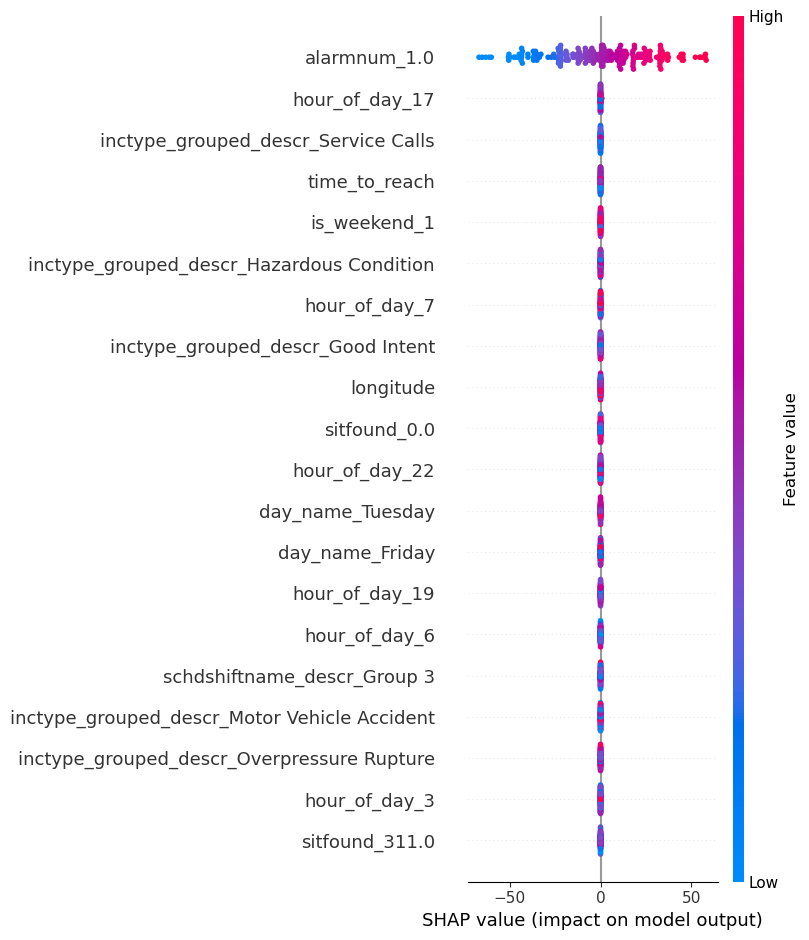

In [11]:
for station_name, df in dataframes.items():
    handle_correlations_and_select_features(station_name, df)

In [12]:
# Combine RF and SHAP features for comparison
feature_comparison = []
for rf, shap in zip(rf_feature_importances, station_feature_importances):
    rf_top = rf['rf_importances']['Feature'].iloc[:10].tolist()
    shap_top = shap['important_features']
    overlap = set(rf_top).intersection(shap_top)
    feature_comparison.append({
        "station_name": rf['station_name'],
        "rf_top_features": rf_top,
        "shap_top_features": shap_top,
        "overlap": list(overlap)
    })

In [13]:
# Print feature comparison results
for comparison in feature_comparison:
    print(f"\nStation: {comparison['station_name']}")
    print(f"RF Top Features: {comparison['rf_top_features']}")
    print(f"SHAP Top Features: {comparison['shap_top_features']}")
    print(f"Overlap: {comparison['overlap']}")


Station: Engine 1
RF Top Features: ['alarmnum_1.0', 'hour_of_day_3', 'count_all_units', 'hour_of_day_6', 'day_name_Tuesday', 'lag_12', 'hour_of_day_9', 'hour_of_day_20', 'hour_of_day_17', 'hour_of_day_12']
SHAP Top Features: ['alarmnum_1.0', 'count_all_units', 'hour_of_day_3', 'hour_of_day_6', 'lag_12', 'sitfound_311.0', 'day_name_Monday', 'longitude', 'day_name_Tuesday', 'hour_of_day_15']
Overlap: ['lag_12', 'hour_of_day_6', 'count_all_units', 'day_name_Tuesday', 'hour_of_day_3', 'alarmnum_1.0']

Station: Engine 2
RF Top Features: ['alarmnum_1.0', 'inctype_grouped_descr_Service Calls', 'hour_of_day_22', 'hour_of_day_0', 'hour_of_day_7', 'hour_of_day_21', 'hour_of_day_20', 'count_all_units', 'hour_of_day_8', 'hour_of_day_4']
SHAP Top Features: ['alarmnum_1.0', 'inctype_grouped_descr_Service Calls', 'hour_of_day_22', 'hour_of_day_0', 'hour_of_day_8', 'hour_of_day_21', 'hour_of_day_23', 'hour_of_day_7', 'time_to_reach', 'hour_of_day_4']
Overlap: ['hour_of_day_0', 'hour_of_day_22', 'hour

In [14]:
overlap_data = []

# Loop through the feature_comparison to extract overlaps
for comparison in feature_comparison:
    overlap_data.append({
        "station_name": comparison['station_name'],
        "important_features": comparison['overlap'],
        "num_important_features": len(comparison['overlap'])
    })

feature_importance_df = pd.DataFrame(overlap_data)
feature_importance_df

,station_name,important_features,num_important_features
0,Engine 1,"[lag_12, hour_of_day_6, count_all_units, day_n...",6
1,Engine 2,"[hour_of_day_0, hour_of_day_22, hour_of_day_4,...",8
2,Engine 3,"[hour_of_day_9, inctype_grouped_descr_Smoke & ...",6
3,Engine 5,"[day_name_Wednesday, hour_of_day_20, day_name_...",7
4,Engine 7,"[lag_12, inctype_grouped_descr_Smoke & CO Dete...",8
5,Engine 8,"[lag_1, count_all_units, hour_of_day_20, expnu...",9
6,Engine 9,"[lag_3, hour_of_day_13, is_weekend_1, inctype_...",7
7,Engine 10/Truck 2,"[hour_of_day_16, hour_of_day_9, hour_of_day_19...",8
8,Engine 12,"[lag_3, inctype_grouped_descr_Rescue & EMS, da...",7
9,Engine 13/Truck 10,"[day_name_Monday, hour_of_day_6, day_name_Tues...",7


In [15]:
print(f"No. of SARIMAX models with hyperparameter tuning that are running: {feature_importance_df['num_important_features'].sum()}")

No. of SARIMAX models with hyperparameter tuning that are running: 124


<b>Create final subsets for each station with only important features</b>

In [16]:
feature_importance_dict = {i:j for (i,j) in zip(feature_importance_df['station_name'].tolist(), feature_importance_df['important_features'])}

In [17]:
df_list = []
for (k,d,n) in zip(dataframes.keys(),dataframes.values(),st_names):
    d['month'] = pd.to_datetime(d['datetimealarm_month_year']).dt.month
    d['year'] = pd.to_datetime(d['datetimealarm_month_year']).dt.year
        
    d = d.drop('PERSIDMAKEREP',axis=1)
    
    mask = ((d['datetimealarm_month_year'] >= '2020-03') & 
             (d['datetimealarm_month_year'] <= '2021-06'))
    d['is_covid'] = np.where(mask, 1, 0)
    
    # Create lagged features
    for i in lag_dict[k]:
        d['lag_'+str(i)] = d['monthly_incidents_per_nearest_station_count'].shift(i)  
    
    d = d.dropna().reset_index(drop=True)
    
    d = d[feature_importance_dict[k]+['is_covid','datetimealarm_month_year','monthly_incidents_per_nearest_station_count']]
    globals()[n] = d
    df_list.append(globals()[n])

Removing columns: expnum_0, schdshiftname_<>, 
as these will NOT be affected by covid (domain knowledge based conclusion).

In [18]:
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, levene

def features_influenced_by_covid(df, print_report=False, return_output=False):
    # Separate data into pre-COVID and during-COVID
    pre_covid = df[df['is_covid'] == 0]
    during_covid = df[df['is_covid'] == 1]

    # Function to check normality and variance, then perform appropriate test
    def test_feature(feature, pre_covid, during_covid):
        # Check normality using Shapiro-Wilk test
        pre_covid_normal = shapiro(pre_covid[feature])[1] > 0.05
        during_covid_normal = shapiro(during_covid[feature])[1] > 0.05

        # Check variance equality using Levene's test
        equal_variance = levene(pre_covid[feature], during_covid[feature])[1] > 0.05

        # Perform the appropriate test
        if pre_covid_normal and during_covid_normal:
            # Use t-test if both distributions are normal
            stat, p_value = ttest_ind(pre_covid[feature], during_covid[feature], equal_var=equal_variance)
            test_used = "t-test"
        else:
            # Use Mann-Whitney U test if either distribution is not normal
            stat, p_value = mannwhitneyu(pre_covid[feature], during_covid[feature], alternative='two-sided')
            test_used = "Mann-Whitney U"

        return test_used, stat, p_value

    # Iterate through each feature and perform the test
    output_features = []
    for feature in df.columns:
        if (feature not in (['is_covid','year','month','datetimealarm_month_year'])) & ~(feature.startswith('expnum')) & ~(feature.startswith('schdshiftname')):
            try:
                test_used, stat, p_value = test_feature(feature, pre_covid, during_covid)
                if p_value < 0.05:
                    output_features.append(feature)
                    if print_report:
                        print(f"{feature}: {test_used} p-value = {p_value:.4f}")
            except Exception as e:
                print(f"Error testing feature {feature}: {e}")
                
    if return_output:
        return output_features

In [19]:
print('Features influenced by COVID for:')
print('')
for (d,n) in zip(df_list, st_names):
    print(str(n))
    features_influenced_by_covid(d, print_report = True)
    print('-'*80)
    print('')

Features influenced by COVID for:

df_engine_1_monthly_fs
day_name_Tuesday: Mann-Whitney U p-value = 0.0210
--------------------------------------------------------------------------------

df_engine_2_monthly_fs
hour_of_day_22: t-test p-value = 0.0373
--------------------------------------------------------------------------------

df_engine_3_monthly_fs
--------------------------------------------------------------------------------

df_engine_5_monthly_fs
hour_of_day_20: t-test p-value = 0.0184
alarmnum_1.0: t-test p-value = 0.0357
monthly_incidents_per_nearest_station_count: t-test p-value = 0.0371
--------------------------------------------------------------------------------

df_engine_7_monthly_fs
--------------------------------------------------------------------------------

df_engine_8_monthly_fs
count_all_units: Mann-Whitney U p-value = 0.0265
hour_of_day_15: Mann-Whitney U p-value = 0.0206
--------------------------------------------------------------------------------

d

/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


### Forecasting Independent Features

In [20]:
#Defining list of static variables - variables that would not change with time and therefore should not be forecasted
static_var = ['latitude','longitude']

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [23]:
def predict_features_with_covid_tuning_optimized(station_name, df, is_covid_column = 'is_covid', static_var = static_var, forecast_periods=120):
    """
    Predict selected features for a station considering the impact of COVID-19, with parameter tuning and validation.
    
    Parameters:
        station_name (str): Name of the station.
        df (pd.DataFrame): DataFrame containing historical data for the station.
        selected_features (list): List of features to predict.
        is_covid_column (str): Column name for the COVID-19 indicator.
        forecast_periods (int): Number of periods to forecast (default: 120 months).
    
    Returns:
        pd.DataFrame: Forecasted values for the selected features.
        dict: Validation metrics for each feature.
    """
    selected_features = [i for i in df.columns if (i not in static_var + ['monthly_incidents_per_nearest_station_count','datetimealarm_month_year'])]
    results = {}
    validation_metrics = {}
    static_values = {var: df[var].mean() for var in static_var if var in df.columns}
    static_values[is_covid_column] = 0

    # Define parameter grid for SARIMAX
    p = range(0, 3)  # AR order
    d = range(1, 2)  # Differencing order
    q = range(0, 3)  # MA order
    P = range(0, 2)  # Seasonal AR order
    D = range(1, 2)  # Seasonal differencing order
    Q = range(0,3)  # Seasonal MA order
    param_grid = list(product(p, d, q, P, D, Q))

    # Forecast each feature
    for feature in selected_features:
        #print(f'{station_name}')
        #print(f"Forecasting {feature}:")
        
        # Ensure data is sorted by time
        df = df.sort_values(by='datetimealarm_month_year')
        
        affected_by_covid = feature in features_influenced_by_covid(df, return_output=True)
        
        # Prepare data
        y = df[feature]
        exog = df[[is_covid_column]] if affected_by_covid else None

        # Split data into train and validation sets (80-20 split)
        train_size = int(len(y) * 0.8)
        train_y, val_y = y[:train_size], y[train_size:]
        train_exog, val_exog = (exog[:train_size], exog[train_size:]) if exog is not None else (None, None)

        # Tune SARIMAX parameters
        best_model = None
        best_aic = float('inf')
        best_bic = float('inf')
        best_order = None
        best_seasonal_order = None
        
        for (p, d, q, P, D, Q) in param_grid:
            try:
                # Define SARIMAX model
                model = SARIMAX(
                    train_y, exog=train_exog,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                model_fit = model.fit(disp=False)
                
                # Compare AIC and BIC
                if model_fit.aic < best_aic:
                    best_model = model_fit
                    best_aic = model_fit.aic
                    best_bic = model_fit.bic
                    best_order = (p, d, q)
                    best_seasonal_order = (P, D, Q, 12)
            except:
                continue
        
        if best_model is not None:
            #print(f"Best SARIMAX parameters for {feature}: Order={best_order}, Seasonal Order={best_seasonal_order}")
            #print(f"AIC: {best_aic}, BIC: {best_bic}")
            
            # Validate on the validation set
            val_forecast = best_model.get_prediction(start=train_size, end=len(y) - 1, exog=val_exog)
            val_pred = val_forecast.predicted_mean
            
            rmse = np.sqrt(mean_squared_error(val_y, val_pred))
            mae = mean_absolute_error(val_y, val_pred)
            mape = np.mean(np.abs((val_y - val_pred) / val_y)) * 100
            
            # Store validation metrics
            validation_metrics[feature] = {
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'AIC': best_aic,
                'BIC': best_bic
            }
            #print(f"Validation Metrics for {feature}: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.2f}%")
            
            # Forecast future values
            future_exog = pd.DataFrame({is_covid_column: [0] * forecast_periods}) if affected_by_covid else None
            future_forecast = best_model.get_forecast(steps=forecast_periods, exog=future_exog)
            future_pred = future_forecast.predicted_mean
            
            # Store forecasted values
            results[feature] = future_pred
        else:
            print(f"No suitable model found for {feature}.")
            results[feature] = [np.nan] * forecast_periods
            validation_metrics[feature] = {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 'AIC': np.nan, 'BIC': np.nan}
            
        #print('-'*80)
        #print('')

    # Convert results to DataFrame
    validation_df = pd.DataFrame(validation_metrics)
    forecast_df = pd.DataFrame(results)
    forecast_df['datetimealarm_month_year'] = pd.date_range(
        start=(pd.to_datetime(df['datetimealarm_month_year'].max()) + timedelta(days = 30)).strftime('%Y-%m'), 
        periods=forecast_periods, freq='M'
    )
    
    # Add static variables with their mean values
    for var, value in static_values.items():
        forecast_df[var] = value
    
    return forecast_df, validation_df

In [24]:
forecasted_df_dict = {}
validation_df_dict = {}

for (n,df_fs) in zip(list(dataframes.keys())[8:],df_list[8:]):  
    forecast, validation = predict_features_with_covid_tuning_optimized(n, df_fs)
    forecasted_df_dict[n] = forecast
    validation_df_dict[n] = validation

/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/a

/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/a

/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/a

/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/medhinisridharr/a

#### Saving historical + forecasted data

In [43]:
csv_names = [i.replace(' ','_').replace('/','_').lower() for i in dataframes.keys()]
csv_names

['engine_1',
 'engine_2',
 'engine_3',
 'engine_5',
 'engine_7',
 'engine_8',
 'engine_9',
 'engine_10_truck_2',
 'engine_12',
 'engine_13_truck_10',
 'engine_16_truck_6',
 'engine_17_rescue_11',
 'engine_19',
 'truck_3',
 'truck_4',
 'truck_5']

In [44]:
for (n,v) in zip(csv_names, forecasted_df_dict.values()):
    v.to_csv(f'/Users/medhinisridharr/Documents/University of Rochester/Courses/Fall 2024/Capstone Project/monthly_incident_counts/Forecasted Selected Features/{n}_fc_im_feat.csv',index=False)
    
for (n,v) in zip(csv_names, validation_df_dict.values()):
    v.to_csv(f'/Users/medhinisridharr/Documents/University of Rochester/Courses/Fall 2024/Capstone Project/monthly_incident_counts/Forecasted Selected Features/validation_metrics/{n}_fc_val.csv')

In [59]:
past_future_values_dict = {}
for (csv_n, n,i) in zip(csv_names[8:], list(dataframes.keys())[8:],range(8,16)):
    past_future_values_dict[n] = pd.concat([df_list[i],forecasted_df_dict[n]], ignore_index=True)
    past_future_values_dict[n]['datetimealarm_month_year'] = pd.to_datetime(past_future_values_dict[n]['datetimealarm_month_year'], errors='coerce')
    past_future_values_dict[n]['datetimealarm_month_year'] = past_future_values_dict[n]['datetimealarm_month_year'].dt.strftime('%Y-%m')
    past_future_values_dict[n].to_csv(f'/Users/medhinisridharr/Documents/University of Rochester/Courses/Fall 2024/Capstone Project/monthly_incident_counts/Forecasted Selected Features/Past_Future/{csv_n}_past_future.csv',index=False)